In [20]:
# Add related paths to system path
import sys
sys.path.append("../src")

import numpy as np
import pandas
import matplotlib.pyplot as plt
from models import FDBaseline, PDABaseline, CDABaseline, LinearUCB, Lasso, Ensemble
from utils import mean_confidence_interval, plot_regret, plot_fraction_incorrect
from evaluate import Evaluator

In [21]:
# Load data
data = pandas.read_csv("../data/data.csv", delimiter=',')
print(data.shape)

(5528, 88)


In [22]:
# Define baseline models
fixed = FDBaseline(1) # Define fixed dosage to be 1 (5mg / day)
pharm = PDABaseline()
clinic = CDABaseline()

In [23]:
# Get data for all baselines

# Fixed dosage baseline
fixed_features = fixed.get_features(data)

# Pharmacogenetic dosage baseline
pharm_features = pharm.get_features(data)

# Clinical dosage baseline
clinic_features = clinic.get_features(data)

# Get targets for each set (same targets for each baseline)
targets = fixed.get_targets(data)

In [5]:
# Define evaluators for each model
fixed_eval = Evaluator(fixed)
pharm_eval = Evaluator(pharm)
clinic_eval = Evaluator(clinic)

Fraction of correct decisions: 0.611794500723589


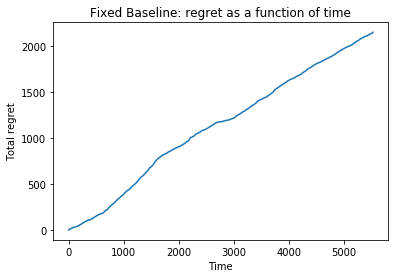

In [6]:

### Evaluate fixed baseline ###

fixed_predictions = fixed.predict(fixed_features)
fixed_acc = fixed_eval.accuracy(fixed_predictions, targets.values)
print("Fraction of correct decisions: " + str(fixed_acc))

fixed_regret = fixed_eval.regret(fixed_predictions, targets.values)
plt.plot(range(fixed_regret.shape[0]), fixed_regret)
plt.title("Fixed Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.6864387593389178


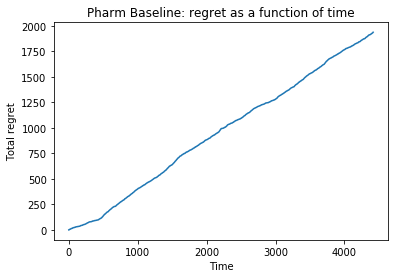

In [7]:

### Evaluate Pharmacogenetic baseline ###

pharm_predictions = pharm.predict(pharm_features.values[~np.isnan(pharm_features).any(axis=1)])
pharm_acc = pharm_eval.accuracy(pharm_predictions, targets.values[~np.isnan(pharm_features).any(axis=1)])
print("Fraction of correct decisions: " + str(pharm_acc))

pharm_regret = fixed_eval.regret(pharm_predictions, targets.values)
plt.plot(range(pharm_regret.shape[0]), pharm_regret)
plt.title("Pharm Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.649083088068825


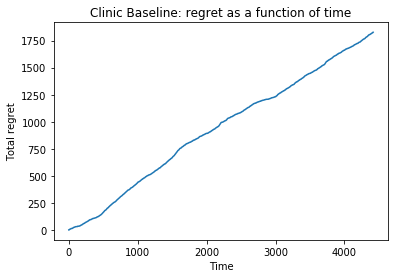

In [8]:

###  Evaluate Clinical baseline ###

clinic_predictions = clinic.predict(clinic_features.values[~np.isnan(clinic_features).any(axis=1)])
clinic_acc = clinic_eval.accuracy(clinic_predictions, targets.values[~np.isnan(clinic_features).any(axis=1)])
print("Fraction of correct decisions: " + str(clinic_acc))

clinic_regret = fixed_eval.regret(clinic_predictions, targets.values)
plt.plot(range(clinic_regret.shape[0]), clinic_regret)
plt.title("Clinic Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

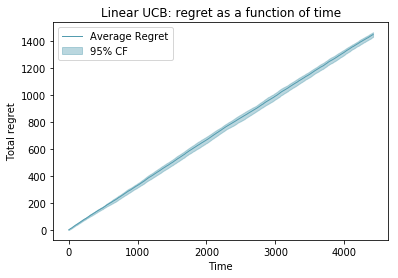

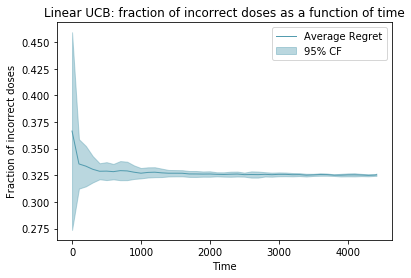

In [9]:

### Linear UCB Model ###

num_iterations = 10

linear_UCB = LinearUCB(num_arms=3, alpha=0.5)
linear_UCB_features = linear_UCB.get_features(data)

num_examples = linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)].shape[0]
linear_UCB_regret = np.zeros((num_iterations, num_examples+1))
linear_UCB_incorrect = np.zeros((num_iterations, int(np.ceil(num_examples/100.0)+1)))

for i in range(num_iterations):
    cur_linear_UCB_regret, cur_linear_UCB_incorrect = linear_UCB.train(linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)], targets.values[~np.isnan(linear_UCB_features).any(axis=1)])
    linear_UCB_regret[i] = np.array(cur_linear_UCB_regret)
    linear_UCB_incorrect[i] = np.array(cur_linear_UCB_incorrect)

# Plot Linear UCB regret
plot_regret(linear_UCB_regret, num_examples, "Linear UCB: regret as a function of time", 
               "Time", "Total regret", "Average Regret", "95% CF")

# Plot Linear UCB fraction incorrect
plot_fraction_incorrect(linear_UCB_incorrect, num_examples, "Linear UCB: fraction of incorrect doses as a function of time", 
                        "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")

/Users/minhanquinn/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


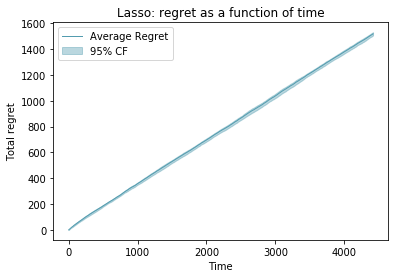

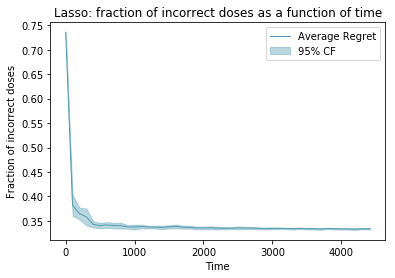

In [10]:

### Lasso Model ###

num_iterations = 10

lasso = Lasso(num_arms=3, lambda1=0.05, lambda2=0.05, h=5, q=1)
lasso_features = lasso.get_features(data)

num_examples = lasso_features.values[~np.isnan(lasso_features).any(axis=1)].shape[0]
lasso_regret = np.zeros((num_iterations, num_examples+1))
lasso_incorrect = np.zeros((num_iterations, int(np.ceil(num_examples/100.0)+1)))

for i in range(num_iterations):
    cur_lasso_regret, cur_lasso_incorrect = lasso.train(lasso_features.values[~np.isnan(lasso_features).any(axis=1)], targets.values[~np.isnan(lasso_features).any(axis=1)])
    lasso_regret[i] = np.array(cur_lasso_regret)
    lasso_incorrect[i] = np.array(cur_lasso_incorrect)
    
# Plot Lasso regret
plot_regret(lasso_regret, num_examples, "Lasso: regret as a function of time", 
               "Time", "Total regret", "Average Regret", "95% CF")

# Plot Lasso incorrect
plot_fraction_incorrect(lasso_incorrect, num_examples, "Lasso: fraction of incorrect doses as a function of time", 
                        "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")

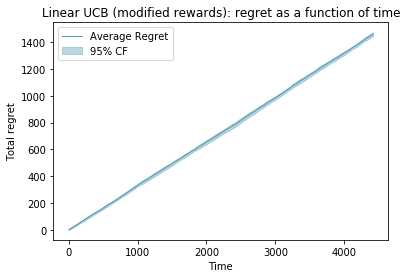

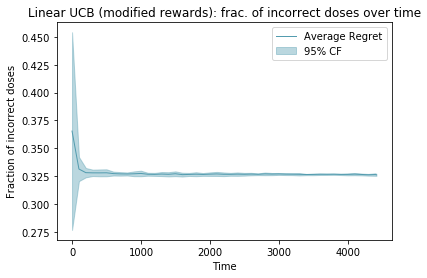

In [11]:

### Linear UCB Model with new reward structure ###

num_iterations = 10

linear_UCB_new_reward = LinearUCB(num_arms=3, alpha=0.5, reward_correct=0, reward_incorrect_1=-1, reward_incorrect_2=-5)
linear_UCB_new_reward_features = linear_UCB_new_reward.get_features(data)

num_examples = linear_UCB_new_reward_features.values[~np.isnan(linear_UCB_new_reward_features).any(axis=1)].shape[0]
linear_UCB_new_reward_regret = np.zeros((num_iterations, num_examples+1))
linear_UCB_new_reward_incorrect = np.zeros((num_iterations, int(np.ceil(num_examples/100.0)+1)))

for i in range(num_iterations):
    cur_linear_UCB_new_reward_regret, cur_linear_UCB_new_reward_incorrect = linear_UCB_new_reward.train(linear_UCB_new_reward_features.values[~np.isnan(linear_UCB_new_reward_features).any(axis=1)], 
                                                                                                        targets.values[~np.isnan(linear_UCB_new_reward_features).any(axis=1)])
    linear_UCB_new_reward_regret[i] = np.array(cur_linear_UCB_new_reward_regret)
    linear_UCB_new_reward_incorrect[i] = np.array(cur_linear_UCB_new_reward_incorrect)

# Plot Linear UCB regret
plot_regret(linear_UCB_new_reward_regret, num_examples, "Linear UCB (modified rewards): regret as a function of time", 
               "Time", "Total regret", "Average Regret", "95% CF")

# Plot Linear UCB fraction incorrect
plot_fraction_incorrect(linear_UCB_new_reward_incorrect, num_examples, "Linear UCB (modified rewards): frac. of incorrect doses over time",
                        "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")


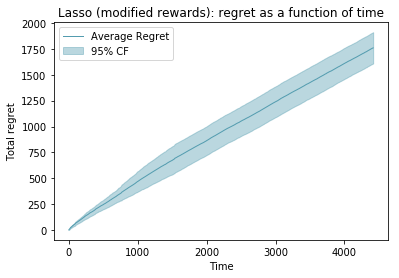

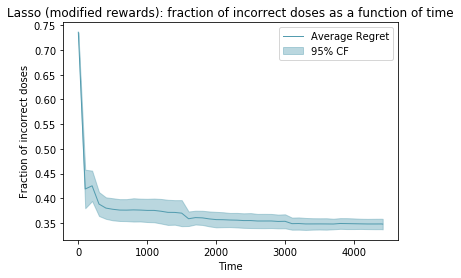

In [12]:

### Lasso Model with new reward structure ###

num_iterations = 10

lasso_new_rewards = Lasso(num_arms=3, lambda1=0.05, lambda2=0.05, h=5, q=1, reward_correct=0, reward_incorrect_1=-1, reward_incorrect_2=-5)
lasso_new_rewards_features = lasso_new_rewards.get_features(data)

num_examples = lasso_new_rewards_features.values[~np.isnan(lasso_new_rewards_features).any(axis=1)].shape[0]
lasso_new_rewards_regret = np.zeros((num_iterations, num_examples+1))
lasso_new_rewards_incorrect = np.zeros((num_iterations, int(np.ceil(num_examples/100.0)+1)))

for i in range(num_iterations):
    cur_lasso_new_rewards_regret, cur_lasso_new_rewards_incorrect = lasso_new_rewards.train(lasso_new_rewards_features.values[~np.isnan(lasso_new_rewards_features).any(axis=1)], targets.values[~np.isnan(lasso_new_rewards_features).any(axis=1)])
    lasso_new_rewards_regret[i] = np.array(cur_lasso_new_rewards_regret)
    lasso_new_rewards_incorrect[i] = np.array(cur_lasso_new_rewards_incorrect)
    
# Plot Lasso regret
plot_regret(lasso_new_rewards_regret, num_examples, "Lasso (modified rewards): regret as a function of time", 
               "Time", "Total regret", "Average Regret", "95% CF")

# Plot Lasso incorrect
plot_fraction_incorrect(lasso_new_rewards_incorrect, num_examples, "Lasso (modified rewards): fraction of incorrect doses as a function of time", 
                        "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")


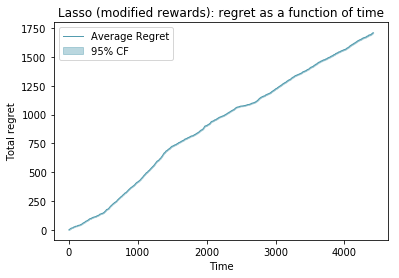

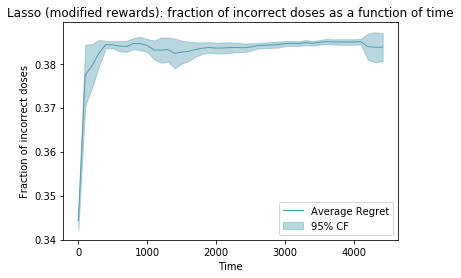

In [13]:

### ENSEMBLE MODEL ###

num_iterations = 10

ensemble = Ensemble(num_arms=3)
ensemble_features, ensemble_CDA_features = ensemble.get_features(data)

num_examples = ensemble_features.values[~np.isnan(ensemble_features).any(axis=1)].shape[0]
ensemble_regret = np.zeros((num_iterations, num_examples+1))
ensemble_incorrect = np.zeros((num_iterations, int(np.ceil(num_examples/100.0)+1)))

for i in range(num_iterations):
    cur_ensemble_regret, cur_ensemble_incorrect = ensemble.train(ensemble_features.values[~np.isnan(ensemble_features).any(axis=1)], ensemble_CDA_features.values[~np.isnan(ensemble_features).any(axis=1)], targets.values[~np.isnan(ensemble_features).any(axis=1)])
    ensemble_regret[i] = np.array(cur_ensemble_regret)
    ensemble_incorrect[i] = np.array(cur_ensemble_incorrect)
    
# # Plot Lasso regret
# plot_regret(ensemble_regret, num_examples, "Lasso (modified rewards): regret as a function of time", 
#                "Time", "Total regret", "Average Regret", "95% CF")

# # Plot Lasso incorrect
# plot_fraction_incorrect(ensemble_incorrect, num_examples, "Lasso (modified rewards): fraction of incorrect doses as a function of time", 
#                         "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")


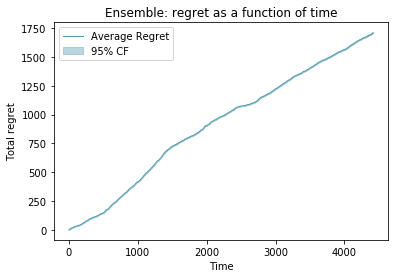

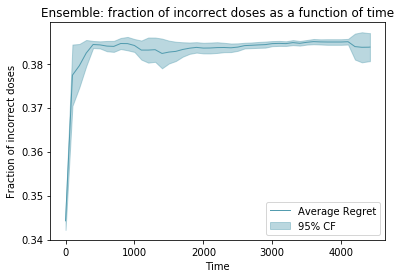

In [14]:
# Plot Lasso regret
plot_regret(ensemble_regret, num_examples, "Ensemble: regret as a function of time", 
               "Time", "Total regret", "Average Regret", "95% CF")

# Plot Lasso incorrect
plot_fraction_incorrect(ensemble_incorrect, num_examples, "Ensemble: fraction of incorrect doses as a function of time", 
                        "Time", "Fraction of incorrect doses", "Average Regret", "95% CF")


In [33]:
X = ensemble_features.values[~np.isnan(ensemble_features).any(axis=1)]
X_CDA = ensemble_CDA_features.values[~np.isnan(ensemble_features).any(axis=1)]
targets_ = targets.values[~np.isnan(ensemble_features).any(axis=1)]

num_incorrect = 0.0

bin_0 = 0.0
bin_1 = 0.0
bin_2 = 0.0

for t in range(X.shape[0]):
    X_t = X[t]
    X_t_CDA = X_CDA[t]
    
    pi_t = np.zeros((5,))
    pi_t[0] = fixed.predict(X_t.reshape((1, X_t.shape[0])))[0]
    pi_t[1] = pharm.predict(X_t.reshape((1, X_t.shape[0])))[0]
    pi_t[2] = clinic.predict(X_t_CDA.reshape((1, X_t_CDA.shape[0])))[0]
    pi_t[3] = linear_UCB.evaluate_single_example(X_t)
    pi_t[4] = lasso.evaluate_single_example(X_t)
    
    counts = np.bincount(pi_t.astype('int64'))
    winners = list(np.argwhere(counts == np.amax(counts)))        
    best_arm = winners[0]
    
    if len(winners) > 1:
        if 1 in winners:
            best_arm = 1
        else:
            best_arm = min(winners)
            
    if best_arm != targets_[t]:
        num_incorrect += 1
        
    if targets_[t] == 0:
        bin_0 += 1
    elif targets_[t] == 1:
        bin_1 += 1
    else:
        bin_2 += 1


In [35]:

### DATASET DISTRIBTION ###
print("bin 0 percentage: " + str(bin_0/targets_.shape[0]))
print("bin 1 percentage: " + str(bin_1/targets_.shape[0]))
print("bin 2 percentage: " + str(bin_2/targets_.shape[0]))
print("")


### FINAL ACCURACIES ###

print("fixed accuracy")
print(fixed_acc)
print("")

print("clinic accuracy")
print(clinic_acc)
print("")

print("pharm accuracy")
print(pharm_acc)
print("")

print("linear ucb accuracy")
print(1- np.mean(linear_UCB_incorrect[:, -1]))
print("")

print("lasso accuracy")
print(1- np.mean(lasso_incorrect[:, -1]))
print("")

print("linear ucb modified rewards accuracy")
print(1- np.mean(linear_UCB_new_reward_incorrect[:, -1]))
print("")

print("lasso modified rewards accuracy")
print(1- np.mean(lasso_new_rewards_incorrect[:, -1]))
print("")

print("ensemble accuracy")
print(1- np.mean(ensemble_incorrect[:, -1]))
print("")

print("independent ensemble accuracy")
print(1-float(num_incorrect) / targets_.shape[0])
print("")

bin 0 percentage: 0.264206474983
bin 1 percentage: 0.614896988906
bin 2 percentage: 0.12089653611

fixed accuracy
0.611794500723589

clinic accuracy
0.649083088068825

pharm accuracy
0.6864387593389178

linear ucb accuracy
0.6744849445324881

lasso accuracy
0.66606293864614

linear ucb modified rewards accuracy
0.6736472719040072

lasso modified rewards accuracy
0.6519357029658139

ensemble accuracy
0.616232737151913

independent ensemble accuracy
0.667874122708

